# RFM metriklerine göre K-Means algoritması ile müşteri segmentasyonu

**Problem**

Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor. Buna yönelik olarak müşterilerin davranışlarını tanımlayacağız ve bu davranışlarda öbeklenmelere göre gruplar oluşturacağız. Ortak davranışlar sergileyenleri aynı gruplara alacağız ve bu gruplara özel satış ve pazarlama teknikleri geliştirmeye çalışacağız.

**Veri Seti**

https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor. Bu çalışmada 2010-2011 yıllarındaki veriler kullanılmıştır.

**Değişkenler**

- InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.
- StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
- Description: Ürün ismi
- Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
- InvoiceDate: Fatura tarihi ve zamanı. 
- UnitPrice: Ürün fiyatı (Sterlin cinsinden)
- CustomerID: Eşsiz müşteri numarası
- Country: Ülke ismi. Müşterinin yaşadığı ülke.



# Data Understanding

In [22]:
#gerekli kütüphaneler import edilmiştir.
import pandas as pd    
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

#Tüm sutünları ve satırları gözlemlemek için kullanılan kod.
pd.set_option('display.max_columns',None); 
pd.set_option("display.max_rows",None);
pd.set_option("display.float_format",lambda x:"%.2f" % x) #ondalık sayılarda virgülden sonra gösterilecek basamak sayısı.

#Data seti okunmuştur.
df_2010_2011 = pd.read_excel("online_retail.xlsx", sheet_name = "Year 2010-2011")
df = df_2010_2011.copy()

# Data Preprocessing

In [23]:
# C ile başlayan fatura numaraları silinmiştir.
df=df[~df["Invoice"].astype(str).str.startswith("C")] 

# Adet ve fiyat çarpılarak toplam tutar hesaplanmıştır."TotalPrice" olarak yeni değişken oluşturulmuştur.
df["TotalPrice"] = df["Quantity"]*df["Price"]

# Eksik veriler silinmiştir.
df.dropna(inplace = True)

# Aykırı değerler
# Aykırı gözlemde 1. ve 3. çeyreklikler göz önüne alınarak IQR hesaplanır ve alt, üst sınırlar burada belirlenir. Bu sınırların dışında kalan değerler aykırı sayılır. 

for feature in ["Quantity","Price"]:
    Q1=df[feature].quantile(0.01)
    Q3=df[feature].quantile(0.99)
    IQR=Q3-Q1
    upper=Q3+1.5*IQR
    lower=Q1-1.5*IQR
    
    if df[(df[feature] > upper) | (df[feature] < lower)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature,"no")
        
    df = df[~((df[feature] > upper) | (df[feature] < lower))] #Bu kod ile aykırı değerler ele alınmamış silinmiş olarak kabul edilmiştir.


Quantity yes
Price yes


## Customer segmentation with RFM skor

In [24]:
# RFM metrikleri

# RECENCY Metrik
import datetime as dt
today_date = dt.datetime(2011,12,9) #en son tarih analizin yapıldığı tarih kabul edilmiştir.
df["Customer ID"] = df["Customer ID"].astype(int)
temp_df = (today_date - df.groupby("Customer ID").agg({"InvoiceDate":"max"}))
temp_df.rename(columns={"InvoiceDate": "Recency"}, inplace = True)
recency_df = temp_df["Recency"].apply(lambda x: x.days) #gün ve saat cinsinden hesaplanan recency değerinden sadece günler yazdırılmıştır.

# FREQUENCY Metrik
temp_df = df.groupby(["Customer ID","Invoice"]).agg({"Invoice":"count"})
freq_df = temp_df.groupby("Customer ID").agg({"Invoice":"count"})
freq_df.rename(columns={"Invoice": "Frequency"}, inplace = True)

# MONETARY Metrik
monetary_df = df.groupby("Customer ID").agg({"TotalPrice":"sum"})
monetary_df.rename(columns = {"TotalPrice": "Monetary"}, inplace = True)
rfm = pd.concat([recency_df, freq_df, monetary_df],  axis=1).reset_index()

rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'].rank(method = "first"), 5, labels = [1,2,3,4,5])
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels = [1,2,3,4,5])
rfm["RFM_SCORE"] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)

seg_map = {
        r'[1-2][1-2]': 'Hibernating',
        r'[1-2][3-4]': 'At Risk',
        r'[1-2]5': 'Can\'t Loose',
        r'3[1-2]': 'About to Sleep',
        r'33': 'Need Attention',
        r'[3-4][4-5]': 'Loyal Customers',
        r'41': 'Promising',
        r'51': 'New Customers',
        r'[4-5][2-3]': 'Potential Loyalists',
        r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map, regex=True)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
0,12347,1,7,4310.00,5,5,5,555,Champions
1,12348,74,4,1437.24,2,4,4,244,At Risk
2,12349,17,1,1417.60,4,1,4,414,Promising
3,12350,309,1,294.40,1,1,2,112,Hibernating
4,12352,35,7,1385.74,3,5,4,354,Loyal Customers


# Clustering with the K-Means Algorithm

In [25]:
#Gerekli kütüphaneler import edilmiştir.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [26]:
#df = rfm[['Recency','Frequency','Monetary']]
df = rfm[['Customer ID','Recency','Frequency','Monetary']]
sc = MinMaxScaler((0,1))
df[['Recency','Frequency','Monetary']] = sc.fit_transform(df[['Recency','Frequency','Monetary']])


D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
kmeans = KMeans(n_clusters = 10)
kmeans_model = kmeans.fit(df[['Recency','Frequency']])
kmeans_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
centers =kmeans_model.cluster_centers_
centers

array([[0.11154993, 0.01140806],
       [0.6755645 , 0.00171743],
       [0.34923794, 0.00623753],
       [0.205899  , 0.00803235],
       [0.97302537, 0.0017177 ],
       [0.01756656, 0.11196094],
       [0.51028474, 0.00453353],
       [0.00306396, 0.61581137],
       [0.03385613, 0.01840195],
       [0.81878889, 0.00162555]])

In [29]:
segments = kmeans_model.labels_
df['Cluster'] = segments+1
df.head()

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Customer ID,Recency,Frequency,Monetary,Cluster
0,12347,0.01,0.03,0.02,9
1,12348,0.20,0.01,0.01,4
2,12349,0.05,0.00,0.01,9
3,12350,0.83,0.00,0.00,10
4,12352,0.10,0.03,0.01,1


In [30]:
df['Cluster'].value_counts()

9     1348
1      837
4      611
3      365
7      348
2      277
10     218
6      172
5      130
8        7
Name: Cluster, dtype: int64

# Görselleştirme

In [31]:
df['RFMSegment'] = np.array(rfm['Segment'])

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Customer Segmentation via RFM Analysis')

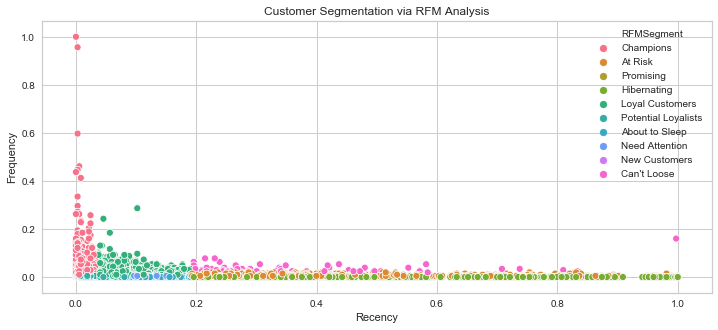

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(df.iloc[:,1], df.iloc[:,2],hue=df['RFMSegment'])
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Customer Segmentation via RFM Analysis')

# RFM Analizi ve K-Means sonucu olusan kumelerin karsilastirilmasi

In [33]:
df.head()

,Customer ID,Recency,Frequency,Monetary,Cluster,RFMSegment
0,12347,0.01,0.03,0.02,9,Champions
1,12348,0.20,0.01,0.01,4,At Risk
2,12349,0.05,0.00,0.01,9,Promising
3,12350,0.83,0.00,0.00,10,Hibernating
4,12352,0.10,0.03,0.01,1,Loyal Customers


In [34]:
df.groupby(['Cluster','RFMSegment'])['RFMSegment'].count()

Cluster  RFMSegment         
1        About to Sleep         235
         Loyal Customers        361
         Need Attention         135
         Potential Loyalists     84
         Promising               22
2        At Risk                 55
         Can't Loose              2
         Hibernating            220
3        At Risk                175
         Can't Loose             16
         Hibernating            174
4        About to Sleep         113
         At Risk                176
         Can't Loose             31
         Hibernating            170
         Loyal Customers         67
         Need Attention          54
5        At Risk                  7
         Can't Loose              1
         Hibernating            122
6        Champions              147
         Loyal Customers         25
7        At Risk                140
         Can't Loose             12
         Hibernating            196
8        Champions                7
9        Champions              475

# Determining the Optimum Number of Clusters

Text(0.5, 1.0, 'Elbow method for Optimum number of clusters')

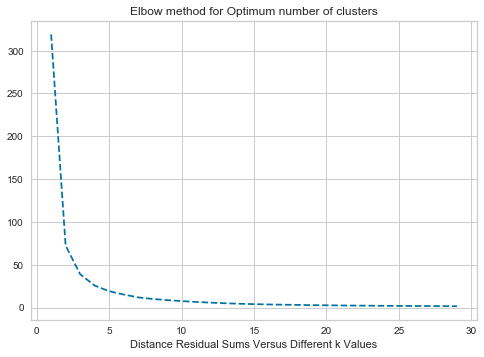

In [45]:
ssd = []

K = range(1,30)

for k in K:
    kmeans = KMeans(n_clusters = k).fit(df[['Recency','Frequency','Monetary']])
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx--")
plt.xlabel("Distance Residual Sums Versus Different k Values")
plt.title("Elbow method for Optimum number of clusters")

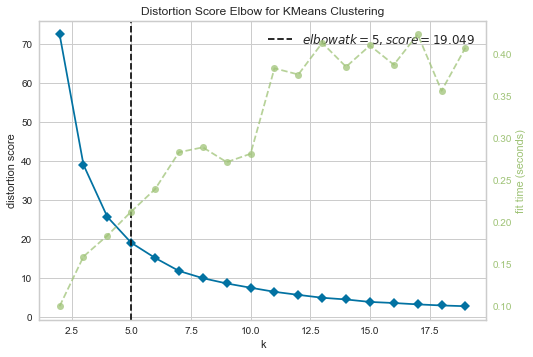

In [39]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visu = KElbowVisualizer(kmeans, k = (2,20))
visu.fit(df[['Recency','Frequency','Monetary']])
visu.poof();

In [41]:
kmeans = KMeans(n_clusters = 5).fit(df[['Recency','Frequency','Monetary']])
kumeler = kmeans.labels_
pd.DataFrame({"Customer ID": rfm.index, "Kumeler": kumeler})
rfm["cluster_no"] = kumeler
rfm["cluster_no"] = rfm["cluster_no"] + 1

In [42]:
rfm.groupby("cluster_no").agg({"cluster_no":"count"})

,cluster_no
cluster_no,
1,2046
2,423
3,517
4,1040
5,287


In [46]:
rfm[["cluster_no", "Recency" , "Frequency" , "Monetary"]].groupby(["cluster_no"]).agg(["mean","count","sum"])

Recency               Frequency              Monetary        \
              mean count     sum      mean count    sum     mean count   
cluster_no                                                               
1            16.76  2046   34284      6.56  2046  13427  2969.68  2046   
2           248.13   423  104960      1.44   423    608   462.46   423   
3           160.18   517   82811      2.09   517   1082   635.52   517   
4            71.92  1040   74793      2.65  1040   2759  1009.97  1040   
5           334.82   287   96093      1.36   287    391   377.25   287   

                       
                  sum  
cluster_no             
1          6075955.56  
2           195622.06  
3           328561.67  
4          1050372.84  
5           108271.16